In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/沥青市场价华东地区.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['市场价（主流价）:沥青（重交沥青）：华东地区'].last_valid_index()                        

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,市场价（主流价）:沥青（重交沥青）：华东地区,Brent原油期货价格,市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格
2025-11-19,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN
2025-11-24,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/市场价沥青华东地区拟合残差-Brent原油期货价格_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')    
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-11-18,79.7
3,2025-11-19,74.2
2,2025-11-20,63.5
1,2025-11-21,50.0
0,2025-11-24,90.1


In [6]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),   
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path3 = None
for path in file_paths3:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path3 = path   
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.read_excel(file_path3, sheet_name='Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['布伦特原油期货价格'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
    sheet3.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

In [7]:
sheet.columns

Index(['市场价（主流价）:沥青（重交沥青）：华东地区', 'Brent原油期货价格',
       '市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格'],
      dtype='object')

In [8]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格'] = sheet_daily['市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# sheet 3
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', 'Brent原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货价格'] = sheet_daily['Brent原油期货价格'].fillna(sheet_daily['Brent原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['Brent原油期货价格预测'])

sheet_daily.tail(10)

,Date,市场价（主流价）:沥青（重交沥青）：华东地区,Brent原油期货价格,市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格
4430,2025-11-12,NaN,78.72,76.1
4431,2025-11-13,NaN,78.82,80.3
4432,2025-11-14,NaN,78.24,79.4
4433,2025-11-17,NaN,78.11,85.0
4434,2025-11-18,NaN,80.16,79.7
4435,2025-11-19,NaN,82.20,74.2
4436,2025-11-20,NaN,81.78,63.5
4437,2025-11-21,NaN,81.46,50.0
4438,2025-11-24,NaN,78.77,90.1
4439,2025-11-25,NaN,78.78,NaN


In [9]:
# 添加新列 主焦煤价格/临汾_预测
sheet_daily['市场价（主流价）:沥青（重交沥青）：华东地区_预测'] = 31.1343*sheet_daily['Brent原油期货价格']+ 1263.1959 + sheet_daily['市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格']
sheet_daily.tail(10)


,Date,市场价（主流价）:沥青（重交沥青）：华东地区,Brent原油期货价格,市场价（主流价）:沥青（重交沥青）：华东地区拟合残差/Brent原油期货价格,市场价（主流价）:沥青（重交沥青）：华东地区_预测
4430,2025-11-12,NaN,78.72,76.1,3790.187996
4431,2025-11-13,NaN,78.82,80.3,3797.501426
4432,2025-11-14,NaN,78.24,79.4,3778.543532
4433,2025-11-17,NaN,78.11,85.0,3780.096073
4434,2025-11-18,NaN,80.16,79.7,3838.621388
4435,2025-11-19,NaN,82.20,74.2,3896.635360
4436,2025-11-20,NaN,81.78,63.5,3872.858954
4437,2025-11-21,NaN,81.46,50.0,3849.395978
4438,2025-11-24,NaN,78.77,90.1,3805.744711
4439,2025-11-25,NaN,78.78,NaN,NaN


---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '市场价（主流价）:沥青（重交沥青）：华东地区']]
historical.columns = ['Date', '市场价（主流价）:沥青（重交沥青）：华东地区']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '市场价（主流价）:沥青（重交沥青）：华东地区_预测']]
forecast.columns = ['Date', '市场价（主流价）:沥青（重交沥青）：华东地区_预测']


# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 去除两列均为空值的行
merged_df_daily = merged_df_daily.dropna(subset=['市场价（主流价）:沥青（重交沥青）：华东地区', '市场价（主流价）:沥青（重交沥青）：华东地区_预测'], how='all')



merged_df_daily.to_excel('eta/市场价（主流价）-沥青（重交沥青）-华东地区_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily.head()

,Date,市场价（主流价）:沥青（重交沥青）：华东地区,市场价（主流价）:沥青（重交沥青）：华东地区_预测
4438,2025/11/24,NaN,3805.744711
4437,2025/11/21,NaN,3849.395978
4436,2025/11/20,NaN,3872.858954
4435,2025/11/19,NaN,3896.635360
4434,2025/11/18,NaN,3838.621388


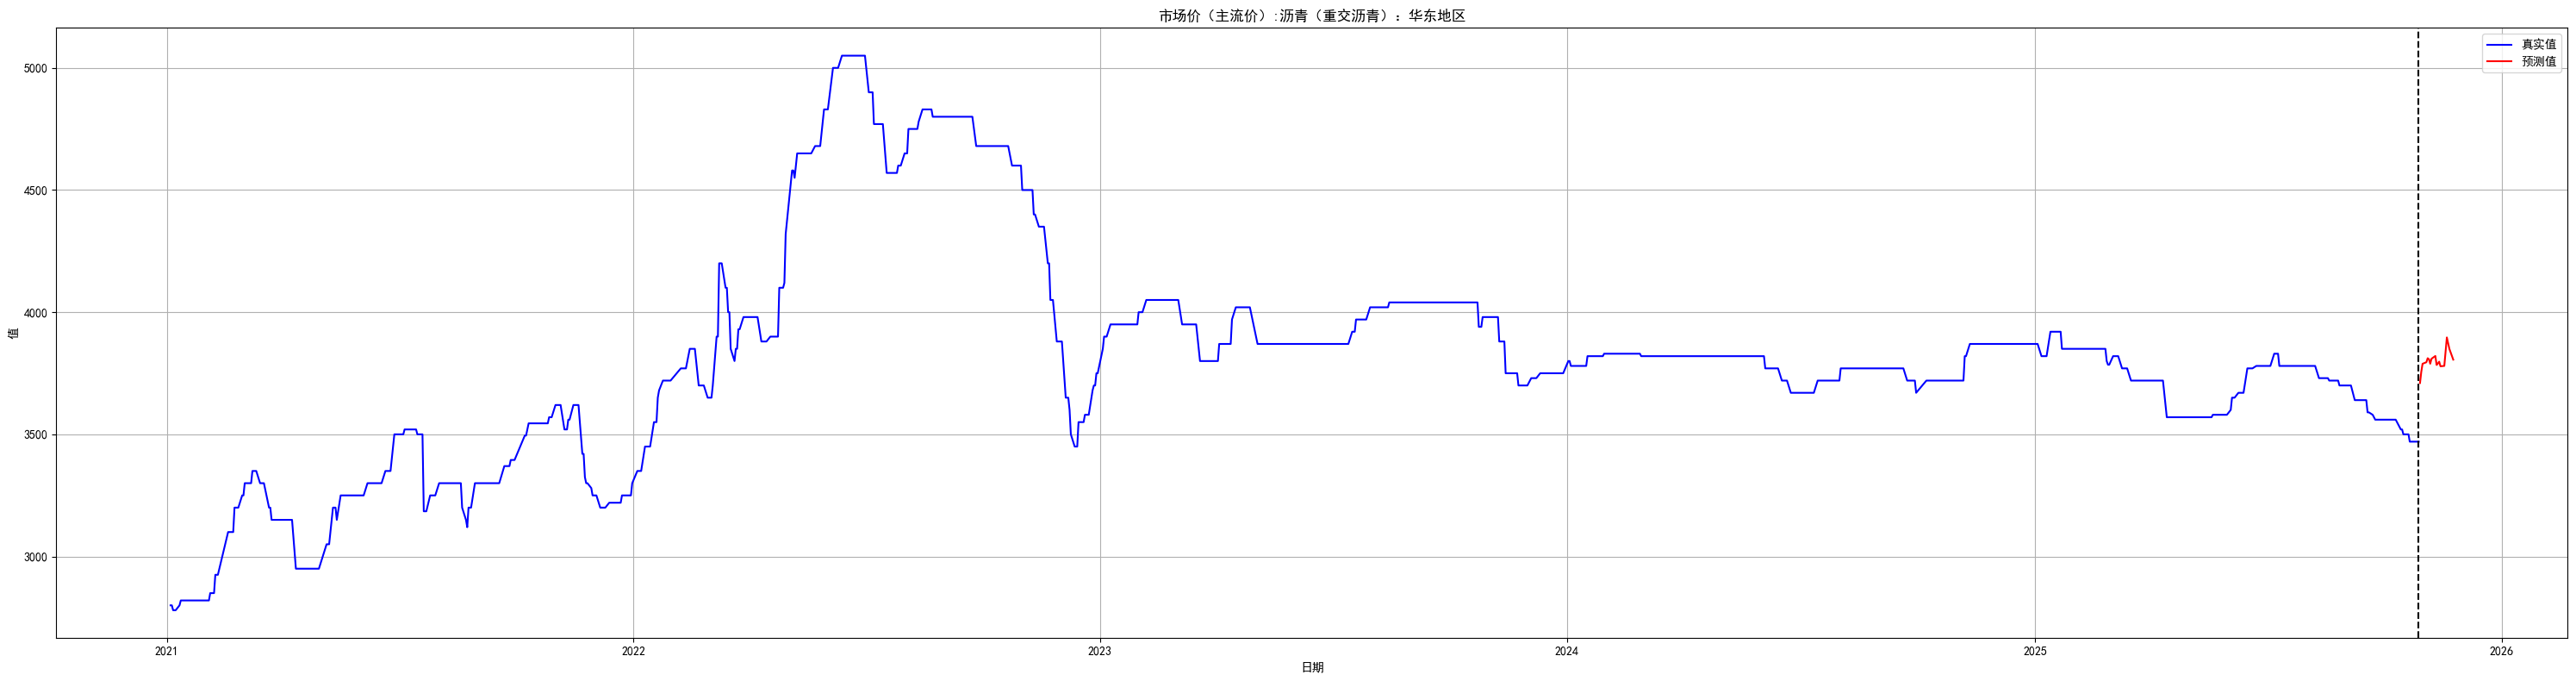

In [11]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot_pf = merged_df_daily.copy()
merged_df_daily_plot_pf['Date'] = pd.to_datetime(merged_df_daily_plot_pf['Date'])

# 筛选2023年及以后的数据
merged_df_daily_plot_pf = merged_df_daily_plot_pf[merged_df_daily_plot_pf['Date'] >= '2021-01-01']

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot_pf['Date'], merged_df_daily_plot_pf['市场价（主流价）:沥青（重交沥青）：华东地区'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot_pf['Date'], merged_df_daily_plot_pf['市场价（主流价）:沥青（重交沥青）：华东地区_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('市场价（主流价）:沥青（重交沥青）：华东地区')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '市场价（主流价）:沥青（重交沥青）：华东地区']]
historical_monthly.columns = ['Date', '市场价（主流价）:沥青（重交沥青）：华东地区']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '市场价（主流价）:沥青（重交沥青）：华东地区_预测']]
forecast_monthly.columns = ['Date', '市场价（主流价）:沥青（重交沥青）：华东地区_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 将数值列保留2位小数
merged_df_monthly['市场价（主流价）:沥青（重交沥青）：华东地区'] = merged_df_monthly['市场价（主流价）:沥青（重交沥青）：华东地区'].round(0)
merged_df_monthly['市场价（主流价）:沥青（重交沥青）：华东地区_预测'] = merged_df_monthly['市场价（主流价）:沥青（重交沥青）：华东地区_预测'].round(0)

merged_df_monthly.to_excel('eta/市场价（主流价）-沥青（重交沥青）-华东地区_月度数据.xlsx', index=False,float_format= '%.4f')            
merged_df_monthly

,Date,市场价（主流价）:沥青（重交沥青）：华东地区,市场价（主流价）:沥青（重交沥青）：华东地区_预测
205,2025/11/30,NaN,3814.0
204,2025/10/31,3504.0,3550.0
203,2025/09/30,3622.0,3625.0
202,2025/08/31,3737.0,3737.0
201,2025/07/31,3789.0,3789.0
...,...,...,...
4,2009/02/28,NaN,NaN
3,2009/01/31,NaN,NaN
2,2008/12/31,NaN,NaN
1,2008/11/30,NaN,NaN


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.沥青_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "市场价（主流价）:沥青（重交沥青）：华东地区"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.沥青_数据上传.xlsx"
sheet_name = "详情页"
identifier = "市场价（主流价）:沥青（重交沥青）：华东地区"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
